# Embeddings Analysis

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import distinctipy
import os
from pathlib import Path
from datasets import load_from_disk, Split
from cuml import TSNE
from ettcl.encoding import ColBERTEncoder
from ettcl.modeling import ColBERTModel, ColBERTTokenizer, ColBERTConfig
from ettcl.indexing import ColBERTIndexer, ColBERTIndexerConfig
from transformers import AutoModelForSequenceClassification
from ettcl.core.pipelines import ClassificationPipeline
from sklearn.metrics import accuracy_score

seaborn.set_theme(style="white")

dataset_path = "~/data/trec-6"
checkpoint = "training/trec-6/colbert/bert-base-uncased/2023-07-23T14:13:05.991002/model_best"

output_dir = "outputs"
text_column = "text"
label_column = "label"

output_dir = os.path.join("outputs", os.path.basename(dataset_path))
plot_dir = os.path.join(output_dir, "plots")
Path(plot_dir).mkdir(exist_ok=True, parents=True)

In [24]:
dataset = load_from_disk(os.path.expanduser(dataset_path))
dataset.set_format("torch")

train_dataset = dataset[Split.TRAIN]
validation_dataset = dataset[Split.VALIDATION]
test_dataset = dataset[Split.TEST]

label_names = train_dataset.features[label_column].names

train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 4906
})

## Load finetuned hyped model

In [25]:
config = ColBERTConfig.from_pretrained(checkpoint, normalize=True)
model = ColBERTModel.from_pretrained(checkpoint, config=config)
tokenizer = ColBERTTokenizer.from_pretrained(checkpoint, add_special_tokens=True, doc_token=None, query_token=None)
encoder = ColBERTEncoder(model, tokenizer)

In [26]:
encoder.cuda()
all_token_embeddings, all_doc_lengths = encoder.encode_passages(validation_dataset[text_column], to_cpu=True)
encoder.cpu();

all_token_embeddings = all_token_embeddings.float()
labels = validation_dataset[label_column]
unique_labels = labels.unique()
num_labels = len(unique_labels)

all_token_embeddings.shape

Encoding:   0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([7386, 128])

In [27]:
baseline_pipeline = ClassificationPipeline(
    model_name_or_path=checkpoint,
    architecture='bert',
)
baseline_preds = baseline_pipeline.predict(validation_dataset['text'])
accuracy_score(validation_dataset[label_column], baseline_preds)

Some weights of the model checkpoint at training/trec-6/colbert/bert-base-uncased/2023-07-23T14:13:05.991002/model_best were not used when initializing BertForSequenceClassification: ['colbert.bert.encoder.layer.1.output.LayerNorm.bias', 'colbert.bert.encoder.layer.8.intermediate.dense.weight', 'colbert.bert.encoder.layer.7.intermediate.dense.bias', 'colbert.bert.encoder.layer.4.attention.self.key.weight', 'colbert.bert.encoder.layer.7.attention.output.LayerNorm.bias', 'colbert.bert.encoder.layer.4.attention.self.value.weight', 'colbert.bert.encoder.layer.6.attention.self.value.bias', 'colbert.bert.encoder.layer.10.attention.output.dense.weight', 'colbert.bert.encoder.layer.3.output.LayerNorm.bias', 'colbert.bert.encoder.layer.6.attention.output.dense.bias', 'colbert.bert.encoder.layer.3.output.LayerNorm.weight', 'colbert.bert.encoder.layer.5.attention.self.query.weight', 'colbert.bert.encoder.layer.11.output.dense.weight', 'colbert.bert.encoder.layer.4.intermediate.dense.bias', 'colbe

0.1978021978021978

In [28]:
accuracy_score(test_dataset[label_column], baseline_pipeline.predict(test_dataset['text']))

0.164

In [ ]:
colbert_pipeline = ClassificationPipeline(
    model_name_or_path=checkpoint,
    architecture='colbert',
    searcher_kwargs={'ncells': 2},
    kwargs={'k': 25},
)

# colbert_pipeline.index_path = "training/trec-6/colbert/bert-base-uncased/2023-07-23T14:13:05.991002/index_best"
# colbert_pipeline.index_dataset = train_dataset
colbert_pipeline.train_index(train_dataset)

In [38]:
colbert_preds = colbert_pipeline.predict(validation_dataset['text'])
accuracy_score(validation_dataset[label_column], colbert_preds)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Searching (num_proc=2):   0%|          | 0/546 [00:00<?, ? examples/s]

0.9377289377289377

In [39]:
accuracy_score(test_dataset[label_column], colbert_pipeline.predict(test_dataset['text']))

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Searching (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

0.972

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

def extract_cls_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int]):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    return embeddings[offsets[:-1]]

def extract_mean_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int]):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    return torch.stack([embeddings[offset:endpos].mean(0) for offset, endpos in zip(offsets[:-1], offsets[1:])])

def extract_prefix_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int]):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    return embeddings[offsets[:-1] + 1]

def extract_pure_token_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int], has_doc_token: bool = False):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    seq_start = 2 if has_doc_token else 1  # removes [CLS] and optional [D],[Q] token
    seq_end = 1  # removes [SEP] token
    new_embeddings = torch.cat([embeddings[offset + seq_start: endpos - seq_end] for offset, endpos in zip(offsets[:-1], offsets[1:])])
    new_lengths = [l - seq_start - seq_end for l in seq_lengths]
    return new_embeddings, new_lengths

def assign_labels(seq_lengths: list[int], labels: list[int]):
    return torch.cat([torch.full((length,), label) for label, length in zip(labels, seq_lengths)])

def assign_doc_ids(seq_lengths: list[int], labels: list[int]):
    return torch.cat([torch.full((length,), doc_id) for doc_id, length in enumerate(seq_lengths)])

def subsample(embeddings: list[torch.Tensor], seq_lengths: list[int], labels: list[int], n: int, stratify: bool = True):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    boundaries = torch.stack([offsets[:-1], offsets[1:]], dim=1)

    if stratify:
        splitter = StratifiedShuffleSplit(n_splits=1, train_size=n)
        random_indices = next(splitter.split(torch.arange(len(boundaries)), labels))[0]
    else:
        random_indices = torch.randperm(len(boundaries))[:n]

    boundaries = boundaries[random_indices]
    lengths = boundaries[:, 1] - boundaries[:, 0]
    labels = assign_labels(lengths, labels[random_indices])
    embeddings = torch.cat([embeddings[bound[0]: bound[1]] for bound in boundaries])

    return embeddings, lengths, labels

In [54]:
# config = ColBERTIndexerConfig(num_partitions=len(np.unique(labels)), kmeans_niters=10)
# indexer = ColBERTIndexer(encoder, config)

# index_path = os.path.join(output_dir, "index")
# indexer.index(index_path, train_dataset.with_format('torch')['text'])

index_path = colbert_pipeline.index_path

In [74]:
# loading centroids from index
# centroids = torch.load(os.path.join(index_path, "centroids.pt"), map_location='cpu')

# centroids from model prediction head
# model_with_head = AutoModelForSequenceClassification.from_pretrained(checkpoint)
# weight = model_with_head.classifier.weight.detach()
# bias = model_with_head.classifier.bias.detach()
# centroids = weight

centroids = torch.empty(size=(0, all_token_embeddings.shape[1]))

centroids.shape

torch.Size([0, 128])

In [56]:
cls_token_embeddings = extract_cls_embeddings(all_token_embeddings, all_doc_lengths)
mean_token_embeddings = extract_mean_embeddings(all_token_embeddings, all_doc_lengths)
pure_token_embeddings, pure_token_lengths = extract_pure_token_embeddings(all_token_embeddings, all_doc_lengths)
pure_token_labels = assign_labels(pure_token_lengths, labels)

# pure_token_embeddings, pure_token_lengths, pure_token_labels = subsample(pure_token_embeddings, pure_token_lengths, labels, n=200)
# pure_token_embeddings.shape

In [57]:
# cls_token_embeddings = torch.nn.functional.tanh(
#     model_with_head.bert.pooler.dense(cls_token_embeddings)
# ).detach()

# mean_token_embeddings = torch.nn.functional.tanh(
#     model_with_head.bert.pooler.dense(mean_token_embeddings)
# ).detach()

# pure_token_embeddings = torch.nn.functional.tanh(
#     model_with_head.bert.pooler.dense(pure_token_embeddings)
# ).detach()

In [67]:
def tsne(*embeddings, **kwargs):
    inputs = torch.cat(embeddings)
    offsets = torch.tensor([0] + [t.shape[0] for t in embeddings]).cumsum(dim=0)

    vecs = TSNE(**kwargs).fit_transform(torch.cat(embeddings).numpy())
    vecs = torch.from_numpy(vecs)

    return (vecs[offset:endpos] for offset, endpos in zip(offsets[:-1], offsets[1:]))

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
# centroid_colors = colors
centroid_colors = ['gray'] * num_labels

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [20:08:39.447823] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


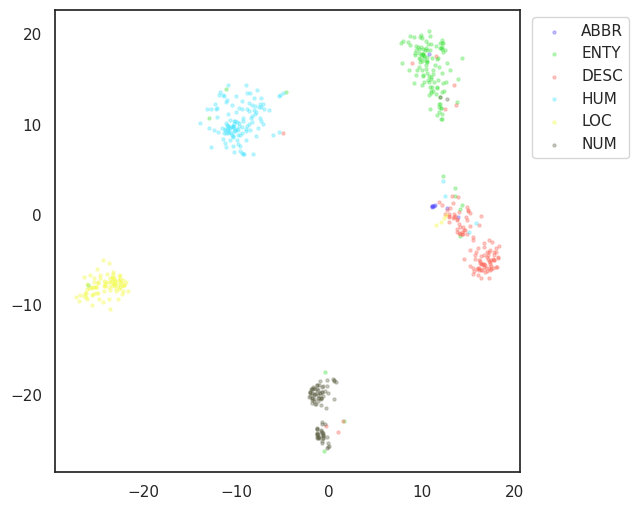

In [76]:
emb_vecs, centroid_vecs = tsne(cls_token_embeddings, centroids, metric='cosine', perplexity=50)

plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

if centroids.shape[0]:
    for i, label in enumerate(unique_labels):
        plt.scatter(*centroid_vecs[i].T, s=150, color=centroid_colors[i], marker='^', alpha=1, edgecolors='black')

    legend_handles = [plt.Line2D([], [], color=centroid_colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
    legend_labels = label_names

    # plt.legend(legend_handles, legend_labels, ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.legend(label_names, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(plot_dir, "cls_token_weight_centroids.pdf"), )

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [20:08:48.060345] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


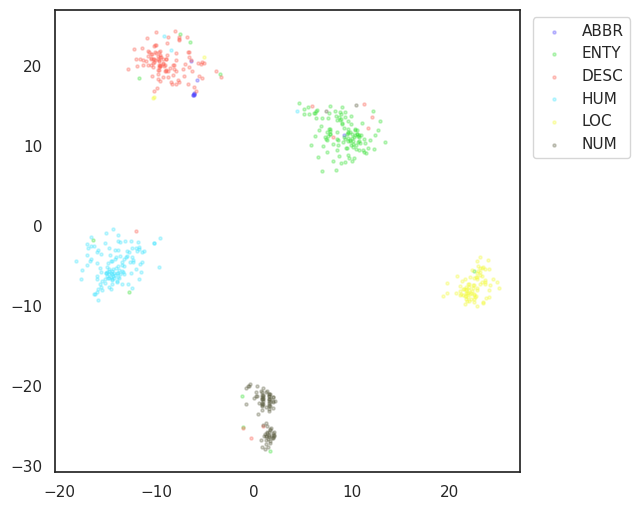

In [77]:
emb_vecs, centroid_vecs = tsne(mean_token_embeddings, centroids, metric='cosine', perplexity=50)

plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

if centroids.shape[0]:
    for i, label in enumerate(unique_labels):
        plt.scatter(*centroid_vecs[i].T, s=150, color=centroid_colors[i], marker='^', alpha=1, edgecolors='black')

    legend_handles = [plt.Line2D([], [], color=centroid_colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
    legend_labels = label_names

    # plt.legend(legend_handles, legend_labels, ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.legend(label_names, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(plot_dir, "mean_token_weight_centroids.pdf"), )

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [20:08:52.648228] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[W] [20:08:52.648296] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


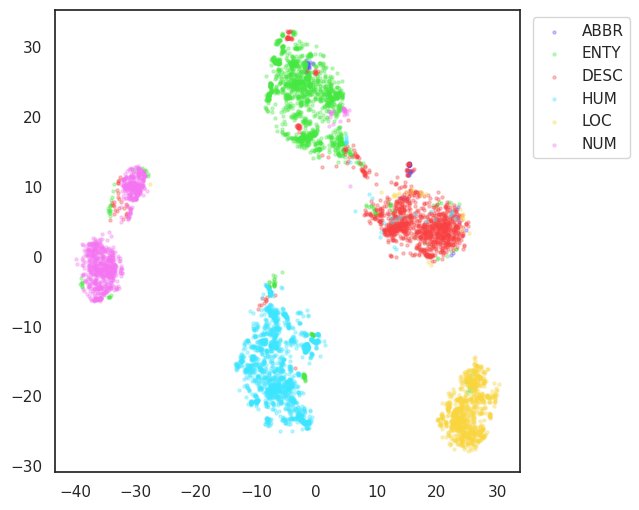

In [78]:
emb_vecs, centroid_vecs = tsne(pure_token_embeddings, centroids, metric='cosine', perplexity=50*5)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[pure_token_labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

if centroids.shape[0]:
    for i, label in enumerate(unique_labels):
        plt.scatter(*centroid_vecs[i].T, s=150, color=centroid_colors[i], marker='^', alpha=1, edgecolors='black')

    legend_handles = [plt.Line2D([], [], color=centroid_colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
    legend_labels = label_names

    # plt.legend(legend_handles, legend_labels, ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.legend(label_names, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(plot_dir, "pure_token_weight_centroids.pdf"), )

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [20:09:27.101782] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[W] [20:09:27.101849] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


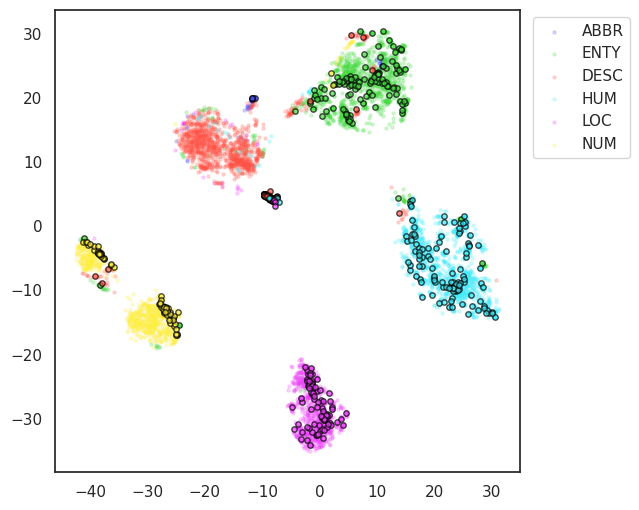

In [80]:
pure_vecs, cls_vecs, centroid_vecs = tsne(pure_token_embeddings, cls_token_embeddings, centroids, metric='cosine', perplexity=50*5)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = pure_vecs[pure_token_labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.2);

for i, label in enumerate(unique_labels):
    vecs_ = cls_vecs[labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=15, alpha=0.7, marker='o', edgecolors='black');

if centroids.shape[0]:
    for i, label in enumerate(unique_labels):
        plt.scatter(*centroid_vecs[i].T, s=150, color=centroid_colors[i], marker='^', alpha=1, edgecolors='black')

    legend_handles = [plt.Line2D([], [], color=centroid_colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
    legend_labels = label_names

    # plt.legend(legend_handles, legend_labels, ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.legend(label_names, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(plot_dir, "all_token_weight_centroids.pdf"))

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [20:10:35.440797] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


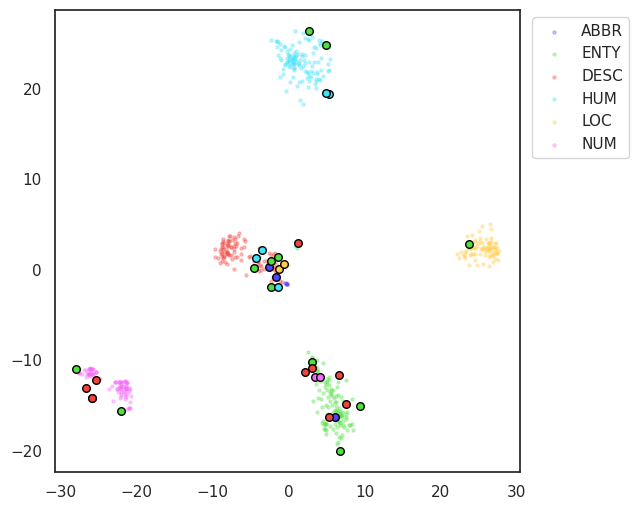

In [82]:
emb_vecs, centroid_vecs = tsne(cls_token_embeddings, centroids, metric='cosine', perplexity=50)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[(labels == label) & (colbert_preds == labels)]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[(labels == label) & (colbert_preds != labels)]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=30, alpha=1, edgecolors='black');

if centroids.shape[0]:
    for i, label in enumerate(unique_labels):
        plt.scatter(*centroid_vecs[i].T, s=150, color=centroid_colors[i], marker='^', alpha=1, edgecolors='black')

    legend_handles = [plt.Line2D([], [], color=centroid_colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
    legend_labels = label_names

    # plt.legend(legend_handles, legend_labels, ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.legend(label_names, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(plot_dir, "cls_token_weight_centroids.pdf"), )

In [84]:
pure_token_baseline_preds = assign_labels(pure_token_lengths, baseline_preds)
pure_token_colbert_preds = assign_labels(pure_token_lengths, colbert_preds)

[W] [20:11:16.815004] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[W] [20:11:16.815115] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


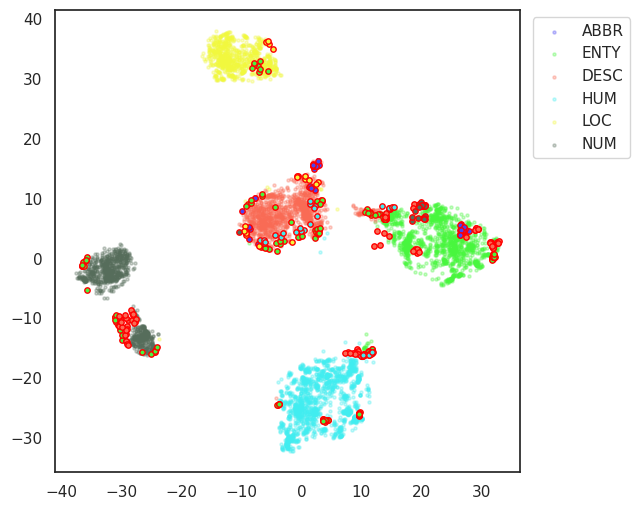

In [85]:
emb_vecs, centroid_vecs = tsne(pure_token_embeddings, centroids, metric='cosine', perplexity=50*5)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[(pure_token_labels == label) & (pure_token_colbert_preds == pure_token_labels)]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[(pure_token_labels == label) & (pure_token_colbert_preds != pure_token_labels)]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=15, alpha=1, edgecolors='red');

if centroids.shape[0]:
    for i, label in enumerate(unique_labels):
        plt.scatter(*centroid_vecs[i].T, s=150, color=centroid_colors[i], marker='^', alpha=1, edgecolors='black')

    legend_handles = [plt.Line2D([], [], color=centroid_colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
    legend_labels = label_names

    # plt.legend(legend_handles, legend_labels, ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.legend(label_names, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(plot_dir, "cls_token_weight_centroids.pdf"), )

## Remove tokens of mismatched validation examples

In [93]:
all_token_ids = validation_dataset.map(lambda batch: tokenizer(batch, truncation="longest_first"), input_columns='text', batched=True)['input_ids']
all_token_ids = torch.cat(all_token_ids)

pure_token_ids, _ = extract_pure_token_embeddings(all_token_ids, all_doc_lengths)

pure_token_ids.shape

Map:   0%|          | 0/546 [00:00<?, ? examples/s]

torch.Size([6294])

In [94]:
# mismatch_token_ids = torch.cat([pure_token_ids[(pure_token_colbert_preds == label) & (pure_token_colbert_preds != pure_token_labels)] for label in unique_labels])
mismatch_token_ids = torch.cat([pure_token_ids[(pure_token_labels == label) & (pure_token_colbert_preds != pure_token_labels)] for label in unique_labels])
mismatch_token_ids.shape

torch.Size([400])

In [95]:
mismatch_token_ids = torch.unique(mismatch_token_ids)
mismatch_token_ids.shape

torch.Size([225])

In [ ]:
skiplist = mismatch_token_ids.tolist()

colbert_pipeline = ClassificationPipeline(
    model_name_or_path=checkpoint,
    architecture='colbert',
    encoder_kwargs={'skiplist': skiplist},
    searcher_kwargs={'ncells': 2},
    kwargs={'k': 25},
)

colbert_pipeline.train_index(train_dataset)

In [98]:
colbert_preds = colbert_pipeline.predict(test_dataset['text'])
accuracy_score(test_dataset[label_column], colbert_preds)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Searching (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


0.582

## Remove train examples

In [86]:
colbert_preds = colbert_pipeline.predict(validation_dataset['text'])

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Searching (num_proc=2):   0%|          | 0/546 [00:00<?, ? examples/s]

In [87]:
missed_val_ids = torch.where(colbert_preds != labels)[0]
missed_validation_labels = labels[colbert_preds != labels]

match_pids = colbert_pipeline.search_result.select(missed_val_ids).with_format('torch')['match_pids']
match_pids = torch.nn.utils.rnn.pad_sequence(list(match_pids), batch_first=True, padding_value=-1)

match_labels = train_dataset[label_column][match_pids.tolist()]

match_pids.shape, match_labels.shape

(torch.Size([34, 10]), torch.Size([34, 10]))

In [88]:
mismatch_mask = match_labels != labels[missed_val_ids].unsqueeze(1)
mismatch_pids = match_pids[mismatch_mask].unique()
mismatch_pids.shape

torch.Size([297])

In [ ]:
filter_pids = mismatch_pids.tolist()

colbert_pipeline = ClassificationPipeline(
    model_name_or_path=checkpoint,
    architecture='colbert',
    searcher_kwargs={'ncells': 2, 'filter_pids': filter_pids},
    kwargs={'k': 25},
)

colbert_pipeline.train_index(train_dataset)

In [92]:
colbert_preds = colbert_pipeline.predict(test_dataset['text'])
accuracy_score(test_dataset[label_column], colbert_preds)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Searching (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

0.968